# Analyse stock price changes during COP

In [1]:
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns

In [2]:
from scipy.stats import ttest_1samp, gstd, kstest, ttest_ind
import statsmodels.api as sm

In [3]:
version = "15"
# This is a switch to allow investigation of multiple sets of companies. Valid options include:
# "renewable_all", "fossil_34", "constsust_34", "greencred_34" and a few assorted variables for one-off investigations.
filetype = "greencred_20"
# Do we want to plot each company's individual behaviour? 
plots_on = False
require_time_start = pd.to_datetime('2011-01-01')
# Do we want to include a period some days before/after the dictionary of events?
# You will need padding for 1-day events (e.g. OPEC meetings, IPCC reports, OilSpills)
padafter = 2
padbefore = 0
# If this variable is not empty/False, we switch to studing a different time series. 
# Options include None = COPs, "OilSpill", "OPEC", 
# "OPEC_28" (only 28 equally spaced OPEC meetings so stats are easier), "OPEC_Conference" 
# (only main conferences, not side meetings), "IPCC"
copOrOther = "OPEC_Conference"
# If this is a string, we subtract some amount of the average fractional change in this filetype (usually constsust_20) 
# to make a linear model of the target variable before calculating statistics. This controls for unusual stock market activity.
norm_group = None #"constsust_20"

In [4]:
if copOrOther:
    output = f"./output/version{version}/{copOrOther}/{filetype}/before{padbefore}_after{padafter}_norm{norm_group}"
else:
    output = f"./output/version{version}/{filetype}/before{padbefore}_after{padafter}_norm{norm_group}"
Path(output).mkdir(exist_ok=True, parents=True)

In [5]:
output

'./output/version15/OPEC_Conference/renewable_20/before0_after2_normNone'

In [6]:
# name of the relevant column in the company df. May be overwritten below depending on filetype. 
close = "Close"
# List of companies whose files we will read
if filetype == "renewable":
    companylist = [
        "0916.HK", "BEP", "EDPR.LS", "FSLR", "NEE", "NHPC.NS", "SUZLON.NS", "VWS.CO", "NPI.TO", "009830.KS"
    ]
elif filetype == "renewable_20":
    companylist = [
        "0916.HK", "BEP", "EDPR.LS", "FSLR", "NEE", "NHPC.NS", "SUZLON.NS", "VWS.CO", "NPI.TO", "009830.KS",
        "ORA", "3800.HK", "PLUG", "NDX1.F", "BLX.TO", "ECV.F", "SLR.MC", "S92.F", "VBK.F", "CSIQ", 
    ]
elif filetype == "fossil":
    companylist = [
        "XOM", "CVX", "SHEL", "601857.SS", "TTE", "COP", "BP", "PBR", "EQNR",  "600028.SS"
    ]
elif filetype == "fossil_20":
    companylist = [
        "XOM", "CVX", "SHEL", "601857.SS", "TTE", "COP", "BP", "PBR", "EQNR",  "600028.SS",
        "0883.HK", "SO", "ENB", "SLB", "DUK", "EOG", "CNQ", "EPD", "E", "OXY"
        
    ]
elif filetype == "constsust_20":
    companylist = ["ABT", "AMZN", "AZN", "BAC", "BRK-B", "COST", "GOOG", "JNJ", "JPM", "KO", 
                  "LLY", "MCD", "MRK", "NESN.SW", "NVO", "PEP", "PG", "ROG.SW", "TYT.L", "WMT"]
elif filetype == "control":
    companylist = ["AAPL", "AMZN", "BRK-B", "GOOG", "LLY", "MSFT", "NVDA", "TSM", "UNH", "V"]
elif filetype == "control_20":
    companylist = ["AAPL", "AMZN", "BRK-B", "GOOG", "LLY", "MSFT", "NVDA", "TSM", "UNH", "V",
                   "HD", "PG", "005930.KS", "MC.PA", "JNJ", "MA", "WMT", "AVGO", "NVO", "JPM"]
elif filetype == "oilprice":
    companylist = ["OilPrice"]
    close = "Adj Close**"
elif filetype == "tmp":
    companylist = ["^SPX"]
elif filetype == "oilfuturesApril":
    companylist = ["CrudeOilWTIFrontMonthApril"]
elif filetype == "greencred_20":
    companylist = ["005930.KS", "AAPL", "ACN", "ADBE", "AMD", "ASML", "AVGO", "CRM", "HD", "MA", 
                   "MC.PA", "MSFT", "NFLX", "NVDA", "NVS", "ORCL", "RMS.PA", "TMO", "UNH", "V"]
elif filetype == "dirty_20": 
    companylist = [
        'XOM', '600519.SS', 'CVX', 'KO', 'RELIANCE.NS',
        'SHEL', '601857.SS', 'WFC', '601288.SS', '601988.SS', 'BA', 'COP',
        'RIO', 'PBR', 'BP', '601088.SS', 'EQNR', 'MO', 'CNQ', 'ITC.NS'
    ]
else:
    companylist = os.listdir(f"./input/{filetype}/")
    companylist = [x[:-4] for x in companylist]
    # In these cases, we expect there to be more than 20 items
    if len(companylist) < 20:
        raise ValueError("Invalid filetype option")

In [7]:
if filetype[-2:] == "20":
    assert len(companylist) == 20

In [8]:
if norm_group:
    if norm_group == "constsust_20":
        companynormlist = ["ABT", "AMZN", "AZN", "BAC", "BRK-B", "COST", "GOOG", "JNJ", "JPM", "KO", 
                  "LLY", "MCD", "MRK", "NESN.SW", "NVO", "PEP", "PG", "ROG.SW", "TYT.L", "WMT"]
    elif norm_group == "control_20":
        companynormlist = ["AAPL", "AMZN", "BRK-B", "GOOG", "LLY", "MSFT", "NVDA", "TSM", "UNH", "V",
                       "HD", "PG", "005930.KS", "MC.PA", "JNJ", "MA", "WMT", "AVGO", "NVO", "JPM"]
    else:
        raise ValueError("Invalid norm_group option")
    assert len(companynormlist) == 20

In [9]:
if not copOrOther:
    copdates = pd.read_csv("./input/CopDates.txt", delimiter="|")
    copdates = copdates.iloc[:, 1:-1]
    copdates.columns = copdates.columns.str.replace('\s+', '')
    copdates["Start"] = pd.to_datetime(copdates["Start"])
    copdates["End"] = pd.to_datetime(copdates["End"])
    meetingstring = "COP number"
    copOrOtherLongstring  = "COP"
elif copOrOther == "OPEC":
    copdates = pd.read_csv("./input/OPEC_all_2002.csv", delimiter=",", parse_dates=["Date"])
    copdates["Start"] = copdates["Date"]
    copdates["End"] = copdates["Date"]
    meetingstring = f"OPEC meeting"
    copOrOtherLongstring = meetingstring
elif copOrOther == "OPEC_Conference":
    copdates = pd.read_csv("./input/OPEC_all_2002.csv", delimiter=",", parse_dates=["Date"])
    copdates["Start"] = copdates["Date"]
    copdates["End"] = copdates["Date"]
    copdates = copdates.drop_duplicates(subset=["Date"], keep="first")
    copdates = copdates.loc[["Meeting of the OPEC Conference" in i for i in copdates["Meeting Title"]]]
    copdates = copdates.reset_index(drop=True)
    meetingstring = f"OPEC meeting"
    copOrOtherLongstring = meetingstring
elif copOrOther == "OPEC_28":
    copdates = pd.read_csv("./input/OPEC_all_2002.csv", delimiter=",", parse_dates=["Date"])
    copdates["Start"] = copdates["Date"]
    copdates["End"] = copdates["Date"]
    copdates = copdates.drop_duplicates(subset=["Date"], keep="first")
    copdates.iloc[np.arange(len(copdates) % 28, len(copdates), (len(copdates) // 28 )), :].reset_index()
    meetingstring = f"OPEC meeting"
    copOrOtherLongstring = meetingstring
elif copOrOther == "OPEC_conf_28":
    copdates = pd.read_csv("./input/OPEC_all_2002.csv", delimiter=",", parse_dates=["Date"])
    copdates["Start"] = copdates["Date"]
    copdates["End"] = copdates["Date"]
    copdates = copdates.loc[["Meeting of the OPEC Conference" in i for i in copdates["Meeting Title"]]]
    copdates = copdates.drop_duplicates(subset=["Date"], keep="first")
    copdates.iloc[np.arange(len(copdates) % 28, len(copdates), (len(copdates) // 28 )), :].reset_index()
    meetingstring = f"OPEC meeting"
    copOrOtherLongstring = meetingstring
elif copOrOther == "OilSpill":
    copdates = pd.read_csv("./input/Oil spills data_v2.csv", delimiter=",", parse_dates=["Date"])
    copdates["Start"] = copdates["Date"]
    copdates["End"] = copdates["Date"]
    meetingstring = f"Oil spill"
    copOrOtherLongstring = meetingstring
elif copOrOther == "IPCC":
    copdates = pd.read_csv("./input/IPCC_dates.csv", delimiter=",", parse_dates=["Date"])
    copdates["Start"] = copdates["Date"]
    copdates["End"] = copdates["Date"]
    meetingstring = "IPCC report"
    copOrOtherLongstring = "IPCC report release"
else:
    raise ValueError("Did not specify a valid copOrOther")
if copOrOther:
    # In all cases, we can't allow duplicate dates so should  flush them out.
    copdates = copdates.drop_duplicates(subset=["Date"], keep="first")

In [10]:
if padbefore:
    copdates["Start"] = copdates["Start"] - timedelta(days=padbefore)
if padafter:
    copdates["End"] = copdates["End"] + timedelta(days=padafter)

# Loop over companies recording behaviour during COP or the same time gap shifted by some weeks

In [11]:
copdates

,Date,Meeting Title,Start,End
0,2002-03-15,119th Meeting of the OPEC Conference,2002-03-15,2002-03-17
1,2002-06-26,120th (Extraordinary) Meeting of the OPEC Conf...,2002-06-26,2002-06-28
2,2002-09-19,121st Meeting of the OPEC Conference,2002-09-19,2002-09-21
3,2002-12-12,122nd (Extraordinary) Meeting of the OPEC Conf...,2002-12-12,2002-12-14
4,2003-01-12,123rd (Extraordinary) Meeting of the OPEC Conf...,2003-01-12,2003-01-14
...,...,...,...,...
60,2020-06-06,179th Meeting of the OPEC Conference,2020-06-06,2020-06-08
61,2020-11-30,180th Meeting of the OPEC Conference,2020-11-30,2020-12-02
62,2021-07-01,181st Meeting of the OPEC Conference,2021-07-01,2021-07-03
63,2021-12-01,182nd Meeting of the OPEC Conference,2021-12-01,2021-12-03


In [12]:
# This code reads the company data and inserts it into the lists aggregate_data and all_data.
# It does not return anything. 
# filetype is the folder with company data, 
# company is the name of the company data file, 
# maxweek is how many weeks before and after the COPs (or similar events) to consider the events.
def read_company_data(filetype, company, maxweek, aggregate_data, all_data):
    file_path = f'./input/{filetype}/{company}.csv'# Name of the variable denoting price at close

    # Read the data from the CSV file into a DataFrame
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df = df[df["Open"] != "-"]
    df.iloc[:, 1:-1] = df.iloc[:, 1:-1].astype(float)
    if len(df[df[close] <= 0 ]) > 0:
        print("Contains negative values!")
        df = df[df[close] > 0 ]
    assert df["Date"].min() < require_time_start, f"Company {company} starts at {df['Date'].min()}, after {require_time_start}"
    df = df[np.isfinite(df[close])]
    # Label periods that are within COP. We consider the day after the close of COP to be included, since it is likely to end
    # on a weekend, and markets will close before final announcements are available.
    # We therefore go from the close of the market day nearest before to the close of the market day after COP.
    offset_results = {}
    for offset in [7*x for x in range(-maxweek, maxweek+1)]:
        copChange = []
        for num, row in copdates.iterrows():
            if (
                row["Start"] + pd.Timedelta(days=offset) > df["Date"].min()
            ) & (row["End"] + pd.Timedelta(days=offset) < df["Date"].max()
            ) & (sum(
                (df["Date"] >= row["Start"] + pd.Timedelta(days=offset)) & (df["Date"] <= row["End"] + pd.Timedelta(days=offset))
            ) > 1):
                copChange.append({
                    "COP": num, 
                    "Before": df.loc[
                        df["Date"] == max(df.loc[df["Date"] < row["Start"] + pd.Timedelta(days=offset), "Date"]), close
                    ].iloc[0],
                    "After":  df.loc[
                        df["Date"] == min(df.loc[df["Date"] > row["End"] + pd.Timedelta(days=offset), "Date"]), close
                    ].iloc[0],
                    "SD": df.loc[
                        (df["Date"] >= row["Start"] + pd.Timedelta(days=offset)) 
                            & ((df["Date"] <= row["End"] + pd.Timedelta(days=offset))), 
                        close
                    ].std(),
                    "geoSD": gstd(df.loc[
                        (df["Date"] >= row["Start"] + pd.Timedelta(days=offset)) 
                            & (df["Date"] <= row["End"] + pd.Timedelta(days=offset)), 
                        close
                    ]), 
                })
        copChange = pd.DataFrame(copChange)
        copChange["diff"] = (copChange["After"] - copChange["Before"]) / copChange["Before"]
        offset_results[offset/7] = copChange
    
    # Analyse the differences
    x = []
    ymean = []
    ystd = []
    yquant = {}
    ystdmean = []
    ygeostdmean = []
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    for key, val in offset_results.items():
        x.append(key)
        ymean.append(val["diff"].mean())
        ystd.append(val["diff"].std())

        ystdmean.append(val["SD"].mean())
        ygeostdmean.append(val["geoSD"].mean())
        yquant[key] = np.quantile(val["diff"], quantiles)
        
    ymean = np.array(ymean)
    ystd = np.array(ystd)
    yquant = pd.DataFrame(yquant, index=quantiles)
    ystdmean = np.array(ystdmean)
    
    # construct illustrative statistics - firstly of the change during the period
    if plots_on:
        plt.figure()
        plt.plot(x, ymean*100)
        plt.fill_between(x, yquant.loc[0.25, :]*100, yquant.loc[0.75, :]*100, alpha=0.3)
        plt.fill_between(x, yquant.loc[0.9, :]*100, yquant.loc[0.1, :]*100, alpha=0.2)
        plt.xlabel("Weeks after COP starts")
        plt.ylabel("Average change during period (%)")
        plt.title(file_path.replace(".csv", ""))
        plt.legend(["Mean", "25-75%", "10-90%"])
        plt.savefig(f"{output}/ChangeIn_{company}.png")

        # Then of the standard deviation during the period
        plt.figure()
        plt.plot(x, ystdmean)
        plt.ylabel("Standard deviation during each period")
        plt.xlabel("Weeks after COP starts")
        plt.savefig(f"{output}/StDev_{company}.png")
    aggregate_data.append(
        pd.DataFrame({
            "company": company, "x": x, "ymean": ymean, 
            "ystd": ystd, "ystdmean": ystdmean, "ygeostdmean": ygeostdmean,
            "y0.1": yquant.loc[0.1,:], "y0.25": yquant.loc[0.25,:], 
            "y0.5": yquant.loc[0.5,:], "y0.75": yquant.loc[0.75,:], "y0.9": yquant.loc[0.9,:]
        })
    )
    for key, val in offset_results.items():
        val["offset"] = key
        all_data.append(val)

In [13]:
aggregate_data = []
all_data = []
maxweek = 24
for company in companylist:
    read_company_data(filetype, company, maxweek, aggregate_data, all_data)

In [14]:
all_data = pd.concat(all_data)

In [15]:
alldata = pd.concat(aggregate_data)

In [16]:
def rowsubtract(df1, df2, frac, cols):
    # A somewhat specialised function to subtract the baseline data from each company for each date.
    # df1 is the baseline data, 
    # df2 is the normalisation data (cannot have a "company" column)
    # cols is a list of columns that should be joined on
    df = pd.merge(df1.reset_index(), df2, on=cols, suffixes=("_raw", "_norm")).set_index("index")
    for col in [c for c in df1.columns if (c not in cols) and c != "company"]:
        df[col] = df[col + "_raw"] - frac * df[col + "_norm"]
        df = df.drop([col + "_raw", col + "_norm"], axis=1)
    return df

In [17]:
if norm_group:
    aggregate_data_norm = []
    all_norm_data = []
    for company in companynormlist:
         read_company_data(norm_group, company, maxweek, aggregate_data_norm, all_norm_data)
    all_norm_data = pd.concat(all_norm_data)
    allnormsummarydata = pd.concat(aggregate_data_norm).groupby("x").mean()
    all_norm_data_grouped = all_norm_data.groupby(["COP", "offset"]).mean()

In [18]:
if norm_group:
    crosstable = pd.merge(all_data, all_norm_data, on=["COP", "offset"])
    model = sm.OLS(crosstable["diff_x"], sm.add_constant(crosstable["diff_y"]))
    results = model.fit()
    normfrac = results.params["diff_y"]
    alldata = rowsubtract(alldata, allnormsummarydata, normfrac, ["x"])
    all_data = rowsubtract(all_data, all_norm_data_grouped, normfrac, ["COP", "offset"])
    print(normfrac)

In [19]:
alldata[alldata["company"]=="CVE"]

,company,x,ymean,ystd,ystdmean,ygeostdmean,y0.1,y0.25,y0.5,y0.75,y0.9


In [20]:
compav = alldata.groupby("x").mean()
compmed = alldata.groupby("x").median()
compav.head()

,ymean,ystd,ystdmean,ygeostdmean,y0.1,y0.25,y0.5,y0.75,y0.9
x,,,,,,,,,
-24.0,0.002628,0.060922,10.357758,1.017409,-0.055205,-0.022380,0.001400,0.027088,0.063944
-23.0,0.008930,0.073670,11.412856,1.017870,-0.057868,-0.023267,0.006682,0.035044,0.074038
-22.0,0.013187,0.060335,11.201848,1.017558,-0.051460,-0.021309,0.009989,0.045454,0.079530
-21.0,0.001432,0.063887,11.599860,1.017382,-0.058889,-0.028273,-0.001458,0.025721,0.052945
-20.0,-0.006650,0.061095,13.315617,1.017362,-0.067933,-0.037636,-0.009013,0.019509,0.050691


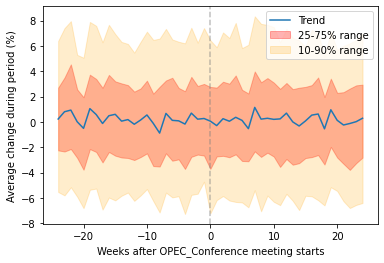

In [21]:
weeksafterstr = f"Weeks after {copOrOther + ' meeting' if copOrOther else 'COP'} starts"
plt.plot(compav.index, compmed.ymean*100)
plt.fill_between(compav.index, compav.loc[:, "y0.25"]*100, compav.loc[:, "y0.75"]*100, alpha=0.3, color="red")
plt.fill_between(compav.index, compav.loc[:, "y0.9"]*100, compav.loc[:, "y0.1"]*100, alpha=0.2, color="orange")
#plt.scatter([0], latestData["diff"].mean() * 100, marker="x")
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
plt.ylabel("Average change during period (%)")
plt.xlabel(weeksafterstr)
plt.legend(["Trend", "25-75% range", "10-90% range"])
plt.savefig(f"{output}/AverageChange.png")

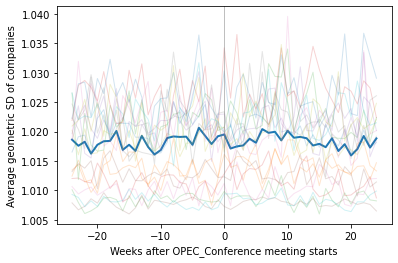

In [22]:
plt.plot(compmed.index, compmed.ygeostdmean, linewidth=2)
plt.ylabel("Average geometric SD of companies")
plt.xlabel(weeksafterstr)
for c in alldata.company.unique():
    plt.plot(alldata.loc[alldata.company==c, "x"], alldata.loc[alldata.company==c, "ygeostdmean"], alpha=0.2, linewidth=1)
plt.axvline(x=0, color='grey', linewidth=1, alpha=0.5)
plt.savefig(f"{output}/AverageStD.png")

In [23]:
companygeostdmean = alldata.groupby("company").mean().loc[:, ["ygeostdmean", "ystdmean"]]
companynorms = pd.merge(alldata, companygeostdmean.reset_index(), on="company").set_index("x")
normed_geostds = companynorms["ygeostdmean_x"] / companynorms["ygeostdmean_y"]
normedgroupedgeostds = normed_geostds.groupby(companynorms.index).mean()

In [24]:
normed_stds = companynorms["ystdmean_x"] / companynorms["ystdmean_y"]
normedgroupedstds = normed_stds.groupby(companynorms.index).mean()

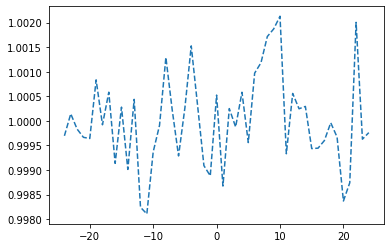

In [25]:
plt.plot(normedgroupedgeostds.index, normedgroupedgeostds, linestyle="--")

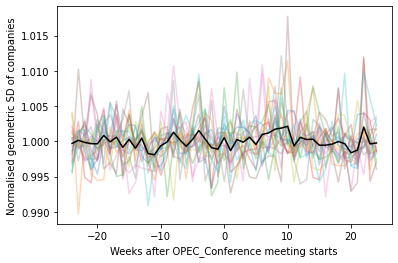

In [26]:
lenset = len(normed_geostds) / len(normedgroupedgeostds)
lencompany = len(normedgroupedgeostds)
for i in range(int(lenset)):
    plt.plot(
        normed_geostds.iloc[lencompany*i:lencompany*i+lencompany].index,
        normed_geostds.iloc[lencompany*i:lencompany*i+lencompany], 
        alpha=0.3
    )
plt.plot(normedgroupedgeostds.index, normedgroupedgeostds, color="black")
plt.ylabel("Normalised geometric SD of companies")
plt.xlabel(weeksafterstr)
plt.savefig(f"{output}/NormedAverageStD.png")

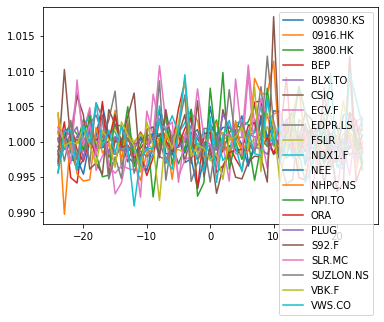

In [27]:
for i in range(20):
    plt.plot(
        normed_geostds.iloc[lencompany*i:lencompany*i+lencompany].index, 
        normed_geostds.iloc[lencompany*i:lencompany*i+lencompany], 
        alpha=1, 
        label=companygeostdmean.index[i]
    )
plt.legend()

In [28]:
definitelynotcops = all_data.loc[
        (all_data["offset"]!=0)&(all_data["offset"]!=1)&(all_data["offset"]!=-1)&(
            all_data["offset"]!=2)&(all_data["offset"]!=-2)&(all_data["offset"]!=3)&(all_data["offset"]!=-3),
    :]
distofcops = np.quantile(
    definitelynotcops["diff"],
    [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
)
distofcopsGeoSD = np.quantile(
    definitelynotcops["geoSD"],
    [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
)
distofcops = [i*100 for i in distofcops]

In [29]:
copnum = len(copdates)

In [30]:
copdates

,Date,Meeting Title,Start,End
0,2002-03-15,119th Meeting of the OPEC Conference,2002-03-15,2002-03-17
1,2002-06-26,120th (Extraordinary) Meeting of the OPEC Conf...,2002-06-26,2002-06-28
2,2002-09-19,121st Meeting of the OPEC Conference,2002-09-19,2002-09-21
3,2002-12-12,122nd (Extraordinary) Meeting of the OPEC Conf...,2002-12-12,2002-12-14
4,2003-01-12,123rd (Extraordinary) Meeting of the OPEC Conf...,2003-01-12,2003-01-14
...,...,...,...,...
60,2020-06-06,179th Meeting of the OPEC Conference,2020-06-06,2020-06-08
61,2020-11-30,180th Meeting of the OPEC Conference,2020-11-30,2020-12-02
62,2021-07-01,181st Meeting of the OPEC Conference,2021-07-01,2021-07-03
63,2021-12-01,182nd Meeting of the OPEC Conference,2021-12-01,2021-12-03


In [31]:
inv = all_data.loc[all_data["offset"]==0, :].reset_index()
inv[inv["diff"]==inv["diff"].max()]

,index,COP,Before,After,SD,geoSD,diff,offset
490,40,46,0.79,1.68,0.403774,1.284551,1.126582,0.0


In [32]:
inv[inv["COP"]==27]

,index,COP,Before,After,SD,geoSD,diff,offset
28,7,27,5.451975,5.579592,0.063400,1.011545,0.023408,0.0
86,2,27,100.419998,98.330002,2.035545,1.020525,-0.020813,0.0
140,25,27,9.073645,9.360292,0.056784,1.006168,0.031591,0.0
199,7,27,233.590729,250.944473,5.683184,1.023196,0.074291,0.0
254,25,27,62.029613,65.736931,0.290660,1.004482,0.059767,0.0
299,16,27,4.755567,4.721466,0.019072,1.004035,-0.007171,0.0
353,25,27,18337.542969,17806.017578,401.794690,1.021991,-0.028986,0.0
394,11,27,38.920650,39.107758,0.321141,1.008311,0.004807,0.0
475,25,27,27.299999,27.500000,0.351189,1.013016,0.007326,0.0
513,9,27,28.230936,27.854874,0.382049,1.013450,-0.013321,0.0


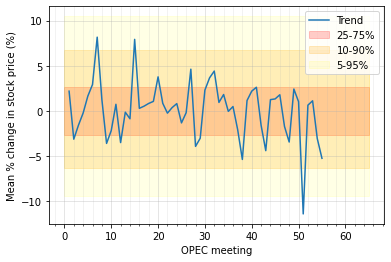

In [33]:
bycop = all_data.loc[all_data["offset"]==0, :].groupby("COP").mean()
plt.rcParams["xtick.minor.visible"] = True
plt.plot(bycop.reset_index(drop=True).index + 1, bycop["diff"] * 100)
plt.fill_between([0, copnum], [distofcops[2], distofcops[2]], [distofcops[4], distofcops[4]], alpha=0.2, color="red")
plt.fill_between([0, copnum], [distofcops[1], distofcops[1]], [distofcops[5], distofcops[5]], alpha=0.2, color="orange")
plt.fill_between([0, copnum], [distofcops[0], distofcops[0]], [distofcops[6], distofcops[6]], alpha=0.1, color="yellow")
plt.grid(True, which='minor', alpha=0.2)
plt.grid(True, which='major', alpha=0.4)
plt.xlabel(meetingstring)
plt.ylabel("Mean % change in stock price (%)")
plt.legend(["Trend", "25-75%", "10-90%", "5-95%"])
plt.savefig(f"{output}/ChangeinStockPricePerCOP.png")

In [34]:
copdates

,Date,Meeting Title,Start,End
0,2002-03-15,119th Meeting of the OPEC Conference,2002-03-15,2002-03-17
1,2002-06-26,120th (Extraordinary) Meeting of the OPEC Conf...,2002-06-26,2002-06-28
2,2002-09-19,121st Meeting of the OPEC Conference,2002-09-19,2002-09-21
3,2002-12-12,122nd (Extraordinary) Meeting of the OPEC Conf...,2002-12-12,2002-12-14
4,2003-01-12,123rd (Extraordinary) Meeting of the OPEC Conf...,2003-01-12,2003-01-14
...,...,...,...,...
60,2020-06-06,179th Meeting of the OPEC Conference,2020-06-06,2020-06-08
61,2020-11-30,180th Meeting of the OPEC Conference,2020-11-30,2020-12-02
62,2021-07-01,181st Meeting of the OPEC Conference,2021-07-01,2021-07-03
63,2021-12-01,182nd Meeting of the OPEC Conference,2021-12-01,2021-12-03


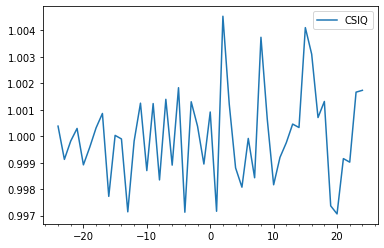

In [35]:
for i in range(5,6):
    plt.plot(
        normed_geostds.iloc[lencompany*i:lencompany*i+lencompany].index, 
        normed_geostds.iloc[lencompany*i:lencompany*i+lencompany], 
        alpha=1, 
        label=companygeostdmean.index[i]
    )
plt.legend()

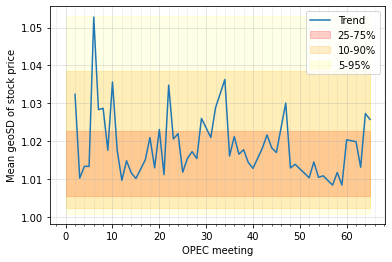

In [36]:
bycop = all_data.loc[all_data["offset"]==0, :].groupby("COP").mean()
plt.rcParams["xtick.minor.visible"] = True
plt.plot(bycop.index + 1, bycop["geoSD"])
plt.fill_between([0, copnum], [distofcopsGeoSD[2], distofcopsGeoSD[2]], [distofcopsGeoSD[4], distofcopsGeoSD[4]], alpha=0.2, color="red")
plt.fill_between([0, copnum], [distofcopsGeoSD[1], distofcopsGeoSD[1]], [distofcopsGeoSD[5], distofcopsGeoSD[5]], alpha=0.2, color="orange")
plt.fill_between([0, copnum], [distofcopsGeoSD[0], distofcopsGeoSD[0]], [distofcopsGeoSD[6], distofcopsGeoSD[6]], alpha=0.1, color="yellow")
plt.grid(True, which='minor', alpha=0.2)
plt.grid(True, which='major', alpha=0.4)
plt.xlabel(meetingstring)
plt.ylabel("Mean geoSD of stock price")
plt.legend(["Trend", "25-75%", "10-90%", "5-95%"])
plt.savefig(f"{output}/ChangeinGeoSDStockPricePerCOP.png")

In [37]:
def copnormfunction(all_data, offset1, distance):
    return all_data.loc[all_data["offset"]==offset1, :].groupby("COP").mean() - ( 
    all_data.loc[all_data["offset"]==offset1 - distance, :].groupby("COP").mean() + 
    all_data.loc[all_data["offset"]==offset1 + distance, :].groupby("COP").mean()
    ) * 0.5
linsubcop_length = 3

In [38]:
distofnormedmeans = pd.concat([
    copnormfunction(all_data, i, linsubcop_length) for i in 
    list(range(-maxweek+linsubcop_length, -1-linsubcop_length)) + list(range(3+linsubcop_length, maxweek-linsubcop_length+1))
])
quants_of_normedCOPs = np.nanquantile(distofnormedmeans["diff"],[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])
quants_of_normedCOPs = [i*100 for i in quants_of_normedCOPs]

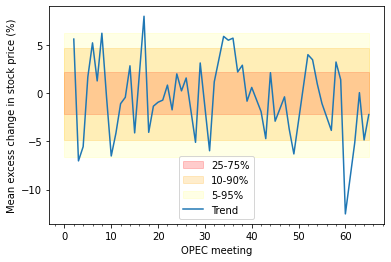

In [39]:
linsubcop = copnormfunction(all_data, 0, linsubcop_length)
plt.fill_between([0, copnum], [quants_of_normedCOPs[2], quants_of_normedCOPs[2]], [quants_of_normedCOPs[4], quants_of_normedCOPs[4]], alpha=0.2, color="red")
plt.fill_between([0, copnum], [quants_of_normedCOPs[1], quants_of_normedCOPs[1]], [quants_of_normedCOPs[5], quants_of_normedCOPs[5]], alpha=0.2, color="orange")
plt.fill_between([0, copnum], [quants_of_normedCOPs[0], quants_of_normedCOPs[0]], [quants_of_normedCOPs[6], quants_of_normedCOPs[6]], alpha=0.1, color="yellow")
plt.xlabel(meetingstring)
plt.plot(linsubcop.index + 1, linsubcop["diff"] * 100)
plt.ylabel("Mean excess change in stock price (%)")
plt.legend(["25-75%", "10-90%", "5-95%", "Trend"])
plt.savefig(f"{output}/NormedChangePerCop.png")

In [40]:
quants_of_normedCOPsGeoSD = np.nanquantile(distofnormedmeans["geoSD"],[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])
quants_of_normedCOPsGeoSD = [i*100 for i in quants_of_normedCOPsGeoSD]

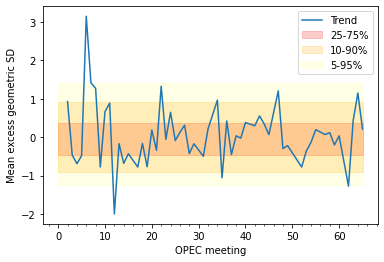

In [41]:
plt.plot(linsubcop.index + 1, linsubcop["geoSD"] * 100)
plt.fill_between([0, copnum], [quants_of_normedCOPsGeoSD[2], quants_of_normedCOPsGeoSD[2]], [quants_of_normedCOPsGeoSD[4], quants_of_normedCOPsGeoSD[4]], alpha=0.2, color="red")
plt.fill_between([0, copnum], [quants_of_normedCOPsGeoSD[1], quants_of_normedCOPsGeoSD[1]], [quants_of_normedCOPsGeoSD[5], quants_of_normedCOPsGeoSD[5]], alpha=0.2, color="orange")
plt.fill_between([0, copnum], [quants_of_normedCOPsGeoSD[0], quants_of_normedCOPsGeoSD[0]], [quants_of_normedCOPsGeoSD[6], quants_of_normedCOPsGeoSD[6]], alpha=0.1, color="yellow")
plt.xlabel(meetingstring)
plt.ylabel("Mean excess geometric SD")
plt.legend(["Trend", "25-75%", "10-90%", "5-95%"])
plt.savefig(f"{output}/NormedGeoSDPerCop.png")

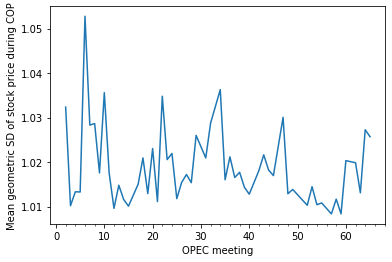

In [42]:
plt.plot(bycop.index + 1, bycop["geoSD"])
plt.xlabel(meetingstring)
plt.ylabel("Mean geometric SD of stock price during COP")
plt.savefig(f"{output}/GeometricSDPerCOP.png")

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , 13.69623624,  0.        ,  0.        ,
         0.        ,  0.        , 13.69623624,  0.        , 13.69623624,
         0.        , 54.78494496, 27.39247248, 54.78494496, 54.78494496,
        41.08870872, 82.17741744, 68.4811812 , 82.17741744, 41.08870872,
        41.08870872, 13.69623624, 27.39247248,  0.        , 41.08870872,
        13.69623624, 27.39247248, 13.69623624, 13.69623624,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

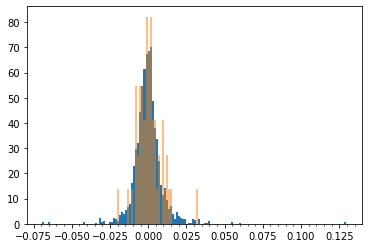

In [43]:
allgeosds = pd.concat([distofnormedmeans["geoSD"], linsubcop["geoSD"]])
bin_edges = np.histogram_bin_edges(allgeosds[~np.isnan(allgeosds)], bins='auto')
plt.hist(distofnormedmeans["geoSD"], density=True, bins=bin_edges)
plt.hist(linsubcop["geoSD"], density=True, bins=bin_edges, alpha=0.5)

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , 13.69623624,  0.        ,  0.        ,
         0.        ,  0.        , 13.69623624,  0.        , 13.69623624,
         0.        , 54.78494496, 27.39247248, 54.78494496, 54.78494496,
        41.08870872, 82.17741744, 68.4811812 , 82.17741744, 41.08870872,
        41.08870872, 13.69623624, 27.39247248,  0.        , 41.08870872,
        13.69623624, 27.39247248, 13.69623624, 13.69623624,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

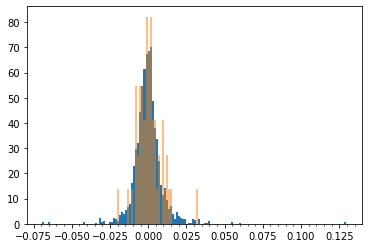

In [45]:
allgeosds = pd.concat([distofnormedmeans["geoSD"], linsubcop["geoSD"]])
bin_edges = np.histogram_bin_edges(allgeosds[~np.isnan(allgeosds)], bins='auto')
plt.hist(distofnormedmeans["geoSD"], density=True, bins=bin_edges)
plt.hist(linsubcop["geoSD"], density=True, bins=bin_edges, alpha=0.5)

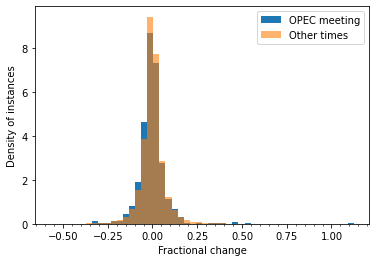

In [46]:
bin_edges = np.histogram_bin_edges(all_data["diff"], bins=50)
plt.hist(all_data[all_data.offset==0]["diff"], density=True, bins=bin_edges)
plt.hist(definitelynotcops["diff"], density=True, bins=bin_edges, alpha=0.6)
plt.xlabel("Fractional change")
plt.ylabel("Density of instances")
plt.legend([copOrOtherLongstring, "Other times"])
plt.savefig(f"{output}/HistogramOfDiffs.png")

In [47]:
alldata

,company,x,ymean,ystd,ystdmean,ygeostdmean,y0.1,y0.25,y0.5,y0.75,y0.9
-24.0,0916.HK,-24.0,-0.003142,0.036363,0.095522,1.013472,-0.035506,-0.030710,-0.003361,0.011796,0.042282
-23.0,0916.HK,-23.0,0.012223,0.043014,0.114289,1.014399,-0.019531,-0.011267,0.003945,0.025681,0.065474
-22.0,0916.HK,-22.0,-0.000543,0.036500,0.079376,1.011465,-0.033814,-0.025498,-0.009091,0.018257,0.044360
-21.0,0916.HK,-21.0,-0.001868,0.042715,0.083635,1.011809,-0.049129,-0.033525,0.003488,0.017895,0.044624
-20.0,0916.HK,-20.0,-0.000698,0.041058,0.064015,1.009527,-0.053718,-0.025092,-0.011290,0.022834,0.050222
...,...,...,...,...,...,...,...,...,...,...,...
20.0,CSIQ,20.0,0.001016,0.069233,0.416383,1.023079,-0.071649,-0.044308,-0.007433,0.038610,0.082025
21.0,CSIQ,21.0,-0.008184,0.088984,0.340581,1.022733,-0.102080,-0.054418,-0.015724,0.031699,0.067067
22.0,CSIQ,22.0,0.005133,0.103962,0.651806,1.036738,-0.117728,-0.093082,0.006360,0.061475,0.135629
23.0,CSIQ,23.0,-0.021024,0.109067,0.580610,1.032898,-0.154615,-0.110371,-0.003980,0.055446,0.100600


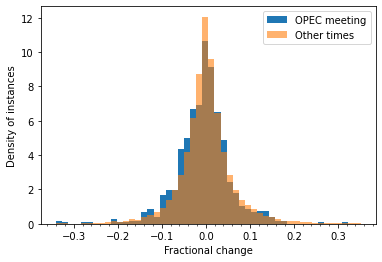

In [50]:
binlimithigh = all_data["diff"].mean() + 5 * all_data["diff"].std()
binlimitlow = all_data["diff"].mean() - 5 * all_data["diff"].std()
bindf = all_data.loc[(all_data["diff"] < binlimithigh) & (all_data["diff"] > binlimitlow), :]
bin_edges = np.histogram_bin_edges(bindf["diff"], bins=50)
plt.hist(bindf.loc[bindf.offset==0]["diff"], density=True, bins=bin_edges)
plt.hist(definitelynotcops.loc[
    (definitelynotcops["diff"] < binlimithigh) & (definitelynotcops["diff"]>binlimitlow), "diff"
], density=True, bins=bin_edges, alpha=0.6)
plt.xlabel("Fractional change")
plt.ylabel("Density of instances")
plt.legend([copOrOtherLongstring, "Other times"])
plt.savefig(f"{output}/HistogramOfDiffs_trunc.png")

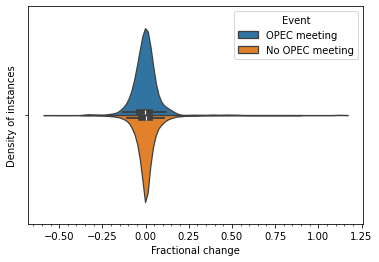

In [51]:
collected_data = pd.concat([
    pd.DataFrame({"Event": copOrOtherLongstring, "Difference": all_data[all_data.offset==0]["diff"]}), 
    pd.DataFrame({"Event": "No " + copOrOtherLongstring, "Difference": definitelynotcops["diff"]}), 
])
sns.violinplot(x=collected_data["Difference"], hue=collected_data["Event"], split=True)
plt.xlabel("Fractional change")
plt.ylabel("Density of instances")
plt.savefig(f"{output}/ViolinOfDiffs.png")

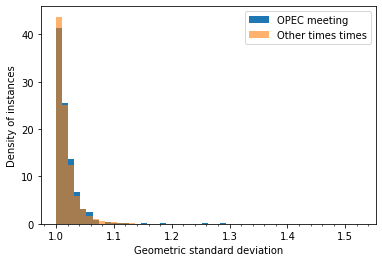

In [52]:
bin_edges = np.histogram_bin_edges(all_data["geoSD"], bins=50)
plt.hist(all_data[all_data.offset==0]["geoSD"], density=True, bins=bin_edges)
plt.hist(definitelynotcops["geoSD"], density=True, bins=bin_edges, alpha=0.6)
plt.xlabel("Geometric standard deviation")
plt.ylabel("Density of instances")
plt.legend([copOrOtherLongstring, "Other times times"])
plt.savefig(f"{output}/HistogramOfGeoSDs.png")

In [53]:
all_data["geoSD"].std()

0.02149276089070871

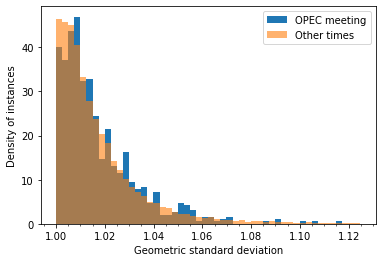

In [54]:
histogramdf = all_data
histlimit = 5*all_data["geoSD"].std() + all_data["geoSD"].mean()
histogramdf = histogramdf[histogramdf["geoSD"] < histlimit]
bin_edges = np.histogram_bin_edges(histogramdf["geoSD"], bins=50)
plt.hist(histogramdf[histogramdf.offset==0]["geoSD"], density=True, bins=bin_edges)
plt.hist(definitelynotcops.loc[definitelynotcops["geoSD"] < histlimit, "geoSD"], density=True, bins=bin_edges, alpha=0.6)
plt.xlabel("Geometric standard deviation")
plt.ylabel("Density of instances")
plt.legend([copOrOtherLongstring, "Other times"])
plt.savefig(f"{output}/HistogramOfGeoSDs_truncated.png")

In [55]:
histogramdf[histogramdf.offset==0]["geoSD"].mean()

1.0172347859838535

In [56]:
definitelynotcops["geoSD"].mean()

1.0177273189122285

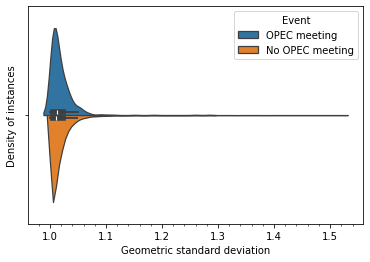

In [57]:
collected_data = pd.concat([
    pd.DataFrame({"Event": copOrOtherLongstring, "Difference": all_data[all_data.offset==0]["geoSD"]}), 
    pd.DataFrame({"Event": "No " + copOrOtherLongstring, "Difference": definitelynotcops["geoSD"]}), 
])
sns.violinplot(x=collected_data["Difference"], hue=collected_data["Event"], split=True)
plt.xlabel("Geometric standard deviation")
plt.ylabel("Density of instances")
plt.savefig(f"{output}/ViolinOfDiffs.png")

In [58]:
alldata[alldata["ymean"] >5]

,company,x,ymean,ystd,ystdmean,ygeostdmean,y0.1,y0.25,y0.5,y0.75,y0.9


In [59]:
all_data[all_data["geoSD"]==all_data["geoSD"].max()]

,COP,Before,After,SD,geoSD,diff,offset
5,6,0.788655,1.302024,0.473488,1.526129,0.650944,-21.0
2,3,0.788655,1.302024,0.473488,1.526129,0.650944,-2.0
1,2,0.788655,1.302024,0.473488,1.526129,0.650944,10.0


In [60]:
definitelynotcops["geoSD"].max()

1.5261290776201797

In [61]:
# Construct a dataframe of the results of KS test and student-T test for 2 samples comparing these populations
KSdiff = kstest(all_data[all_data.offset==0]["diff"], definitelynotcops["diff"])
KSgeoSD = kstest(all_data[all_data.offset==0]["geoSD"], definitelynotcops["geoSD"])
tdiff = ttest_ind(all_data[all_data.offset==0]["diff"], definitelynotcops["diff"])
tgeoSD = ttest_ind(all_data[all_data.offset==0]["geoSD"], definitelynotcops["geoSD"])

higeosd = 5*all_data["geoSD"].std() + all_data["geoSD"].mean()
logeosd = -5*all_data["geoSD"].std() + all_data["geoSD"].mean()
hidiff = 5*all_data["diff"].std() + all_data["diff"].mean()
lodiff = -5*all_data["diff"].std() + all_data["diff"].mean()

truncatedtdiff = ttest_ind(
     [x for x in all_data[all_data.offset==0]["diff"] if (x < hidiff) & (x>lodiff)], 
    [x for x in definitelynotcops["diff"] if (x < hidiff) & (x>lodiff)]
)
truncatedtgeoSD = ttest_ind(
    [x for x in all_data[all_data.offset==0]["geoSD"] if (x < higeosd) & (x > logeosd)], 
    [x for x in definitelynotcops["geoSD"] if (x < higeosd) & (x > logeosd)]
)
kstest_results = pd.DataFrame({
    "Test": ["KSDiff", "KSgeoSD", "t-Diff", "t-geoSD", "t-Diff-truncated", "t-geoSD-truncated", "meandiff", "mediandiff"], 
    "testStat": [KSdiff[0], KSgeoSD[0], tdiff[0], tgeoSD[0], truncatedtdiff[0], truncatedtgeoSD[0],
                 all_data[all_data.offset==0]["diff"].mean() - definitelynotcops["diff"].mean(),
                 all_data[all_data.offset==0]["diff"].median() - definitelynotcops["diff"].median(),
                ], 
    "pval": [KSdiff[1], KSgeoSD[1], tdiff[1], tgeoSD[1], truncatedtdiff[1], truncatedtgeoSD[1], 1, 1], 
})
if norm_group:
    kstest_results = kstest_results.append(pd.DataFrame({
        "Test": ["Normalised"], 
        "testStat": [norm_group],
        "pval": [normfrac]
    }))
kstest_results.to_csv(f"{output}/Kolmogorov_Smirnoff_test_results.csv")
kstest_results

,Test,testStat,pval
0,KSDiff,0.060980,0.007026
1,KSgeoSD,0.047022,0.069035
2,t-Diff,-1.382641,0.166785
3,t-geoSD,0.708916,0.478382
4,t-Diff-truncated,-2.994253,0.002753
5,t-geoSD-truncated,0.522283,0.601477
6,meandiff,-0.003550,1.000000
7,mediandiff,-0.000664,1.000000


In [62]:
alldata[alldata["ygeostdmean"]==alldata["ygeostdmean"].max()]

,company,x,ymean,ystd,ystdmean,ygeostdmean,y0.1,y0.25,y0.5,y0.75,y0.9
10.0,ECV.F,10.0,0.013657,0.135842,0.068497,1.039616,-0.075808,-0.022252,0.001721,0.030786,0.097539


In [63]:
output

'./output/version15/OPEC_Conference/renewable_20/before0_after2_normNone'